# Home Credit Default Risk
このnotebookでは、予測結果を作成するまでの流れと基本的な手法についての紹介を行います。


まずは、今回のタスクについて確認しましょう（詳細はREADME.ipynbをご覧ください）。
- **目的**： 顧客データから債務不履行になる確率を予測する。
- **評価指標**： AUC（Area Under the Curve）

## 目次
0. ライブラリ・データの読み込み
1. データの可視化と分析
2. 前処理と特徴量作成
3. 機械学習モデルの作成
4. 予測結果の作成

## 0. ライブラリ・データの読み込み

基本的なライブラリを読み込みます。
他の必要なライブラリについては、説明をする際に読み込みます。
- numpy：数値計算を効率的に行うライブラリ
- pandas：データ分析に便利なライブラリ
- matplotlib：グラフ描画ライブラリ
- seaborn：グラフ描画ライブラリ

In [108]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


必要なデータの読み込みを行います。GCIの教材フォルダの構成を想定して、読み込んでいます。

In [109]:
# データの読み込み
# INPUT_DIRにtrain.csvなどのデータを置いているディレクトリを指定してください。
INPUT_DIR = "./input/"

train = pd.read_csv(INPUT_DIR + "train.csv")
test = pd.read_csv(INPUT_DIR + "test.csv")
sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")
target =  pd.read_csv(INPUT_DIR + "train.csv")["TARGET"]

In [110]:
train_original = pd.read_csv(INPUT_DIR + "train.csv")

train_head = train_original.head()
train_original.columns


Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60

## 1. データの可視化と分析

### 1.1 データの概観
本格的な分析を行う前に、まずは簡単にデータの概観を確認します。

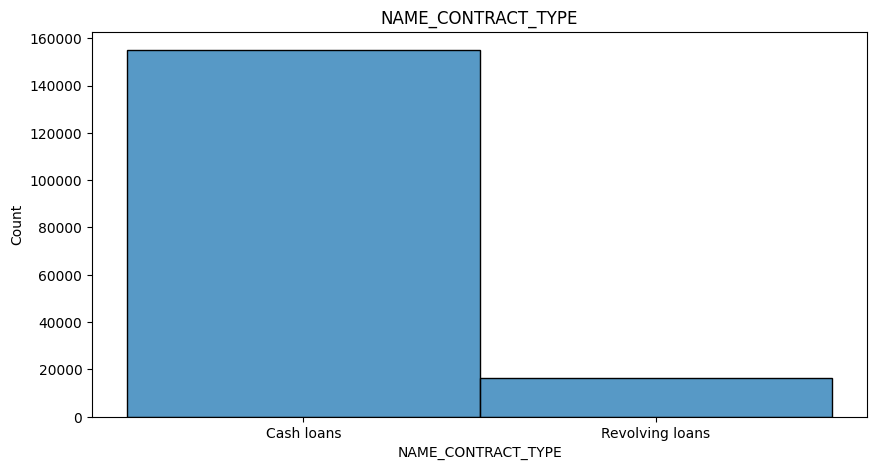

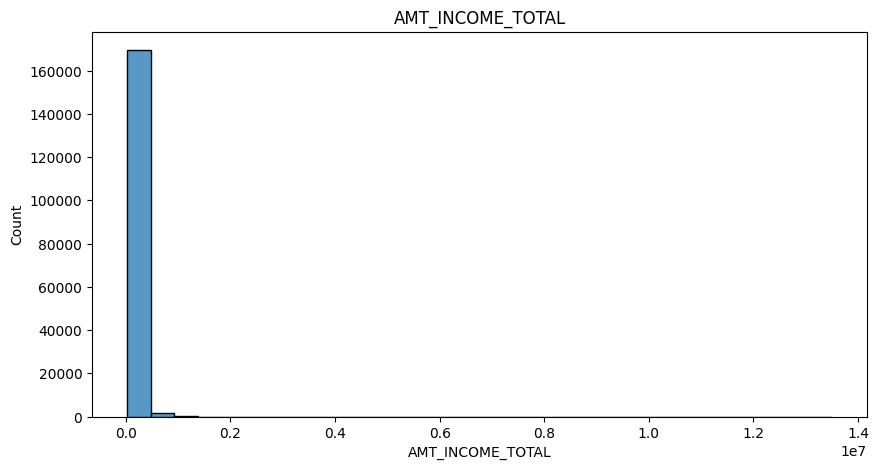

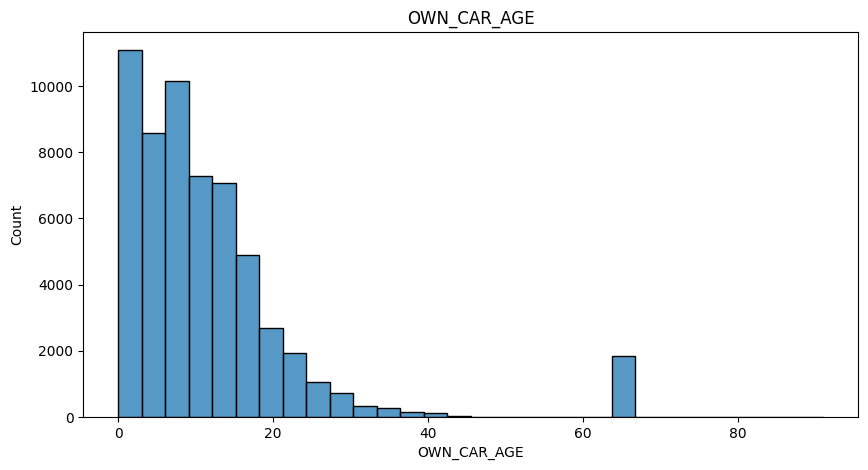

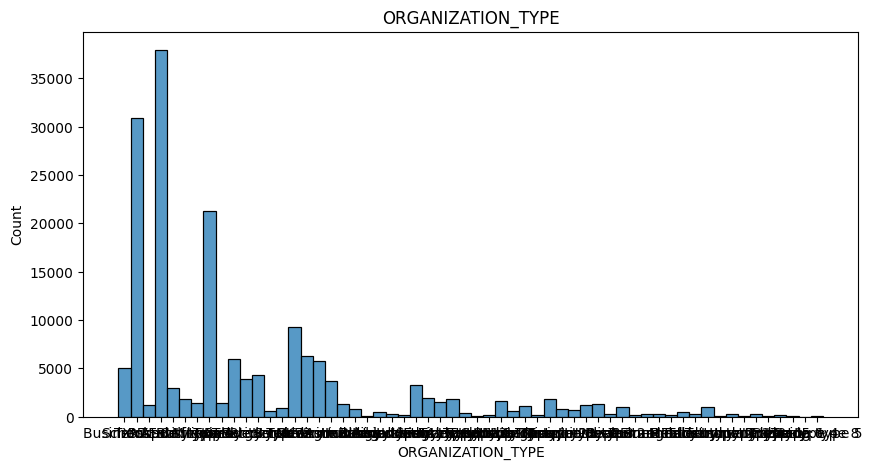

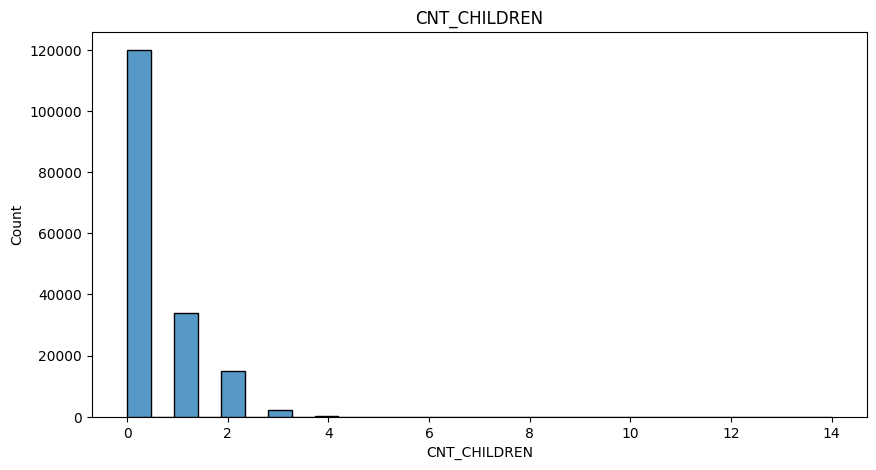

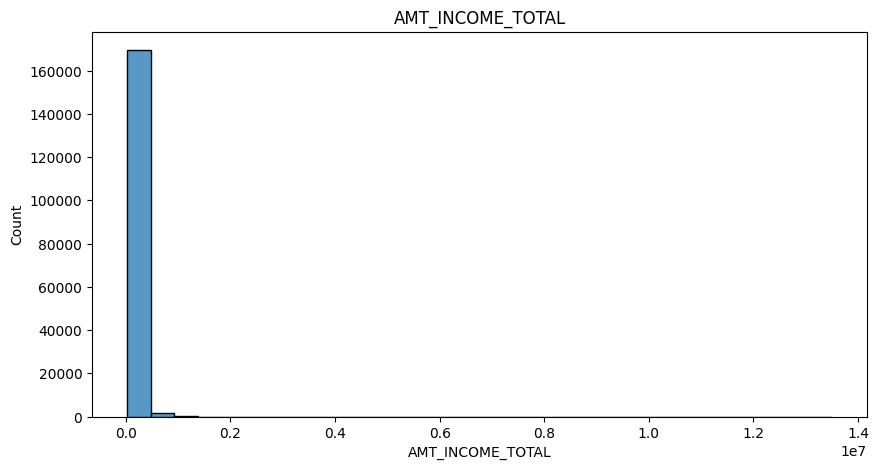

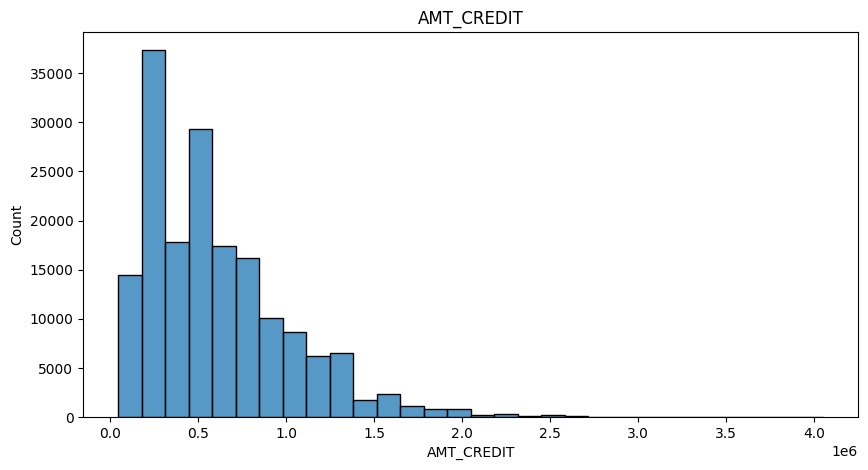

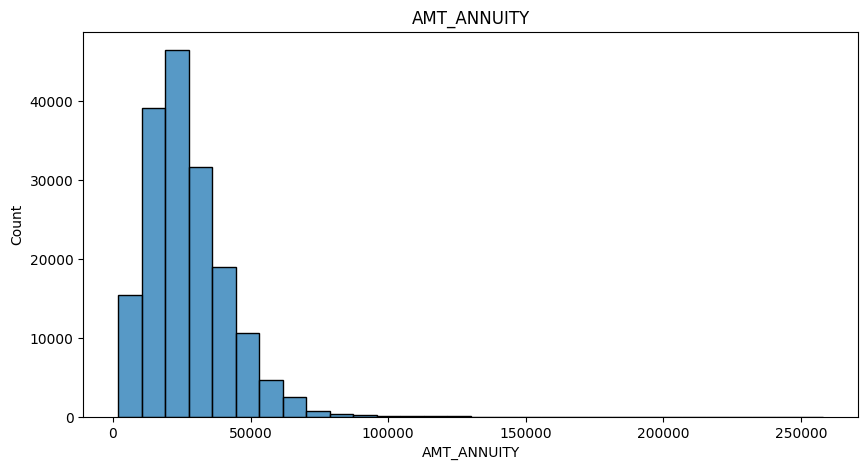

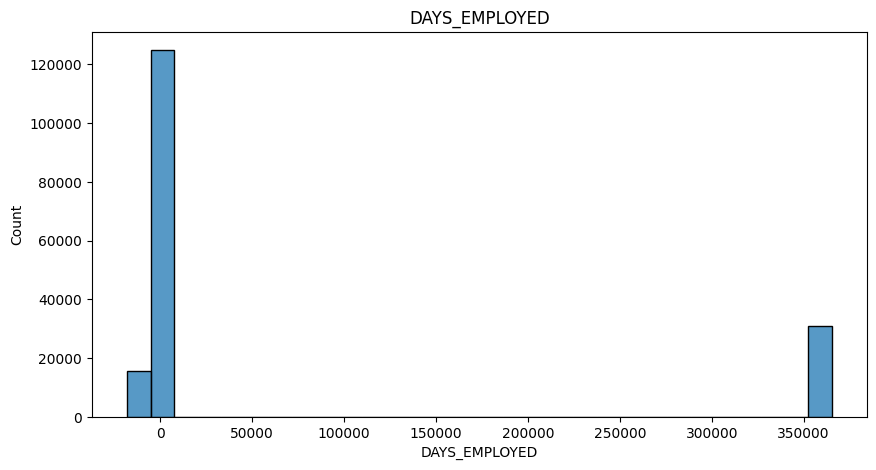

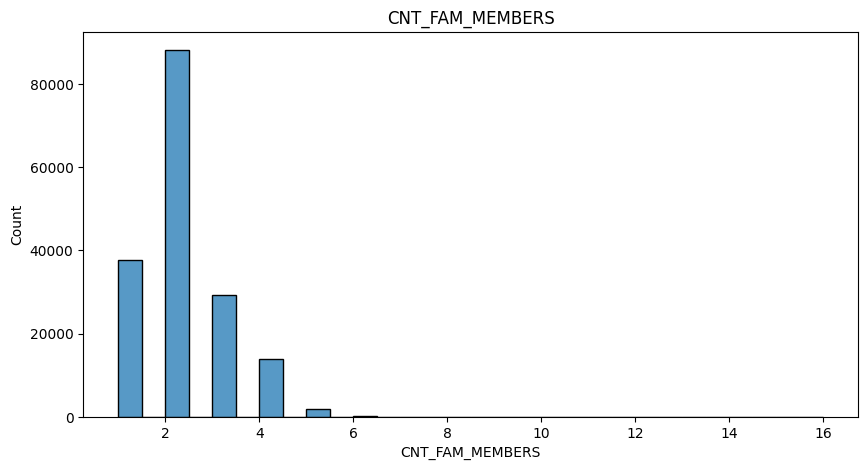

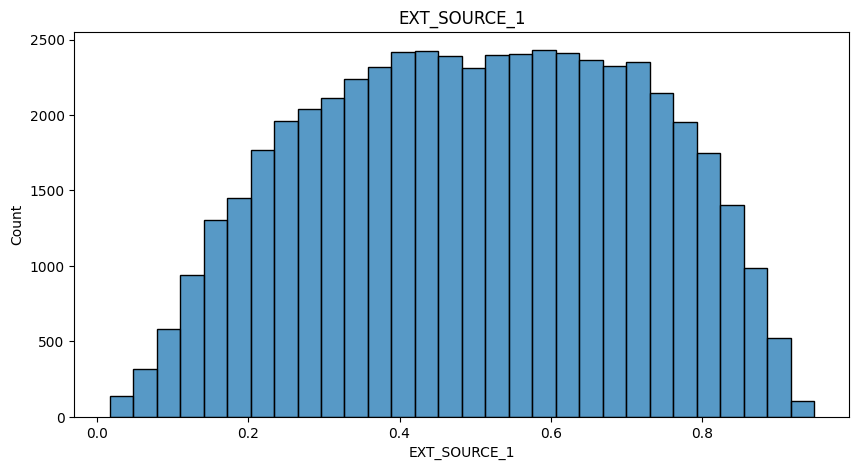

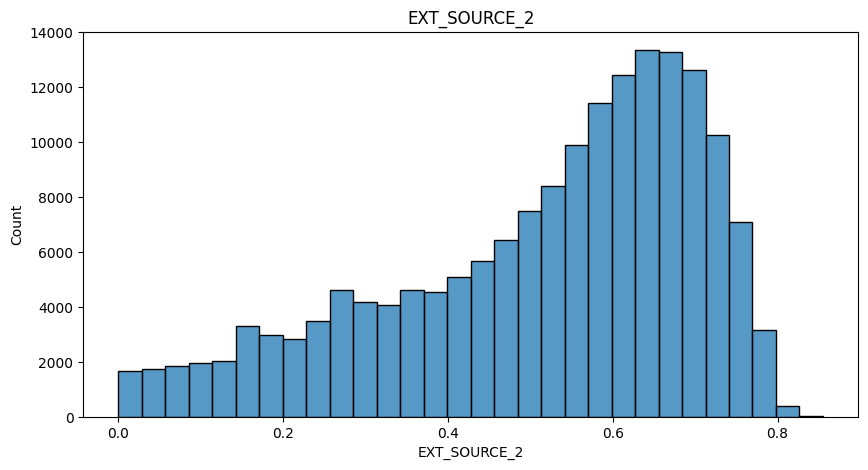

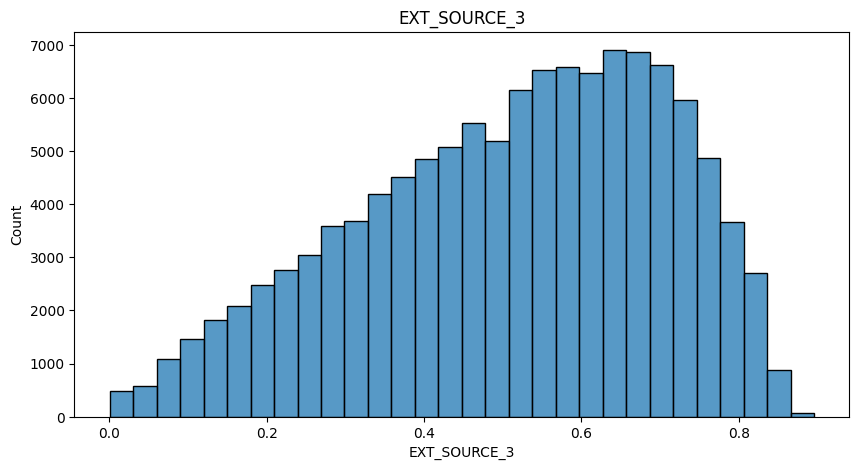

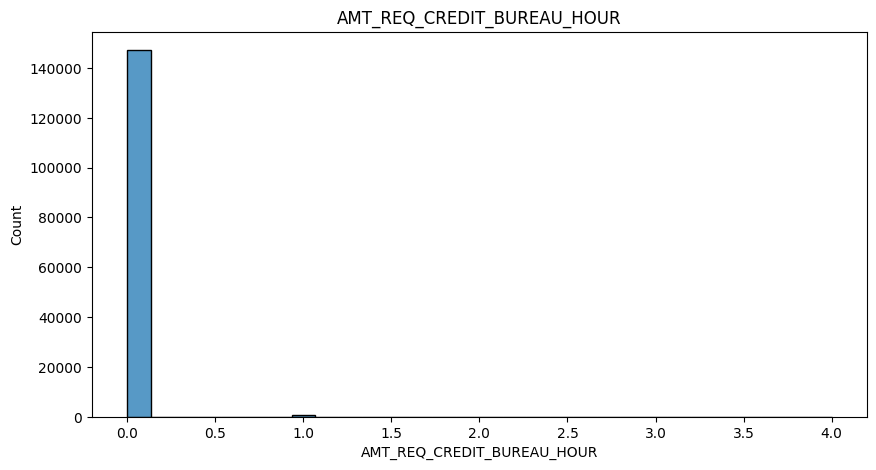

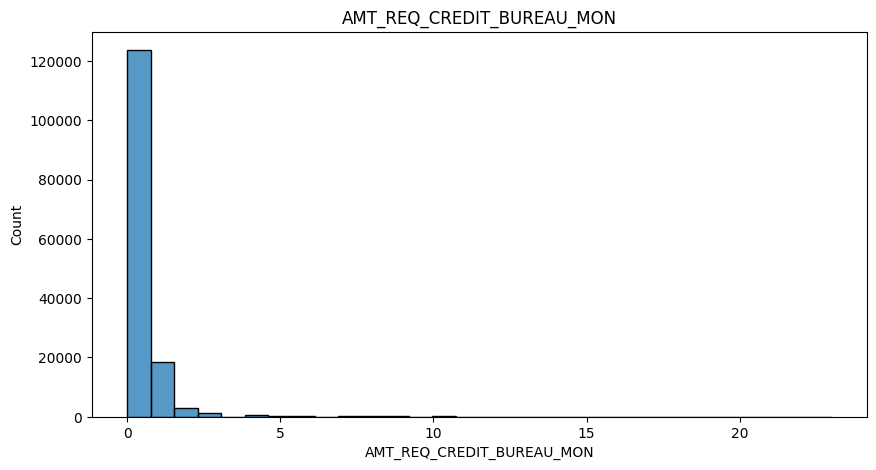

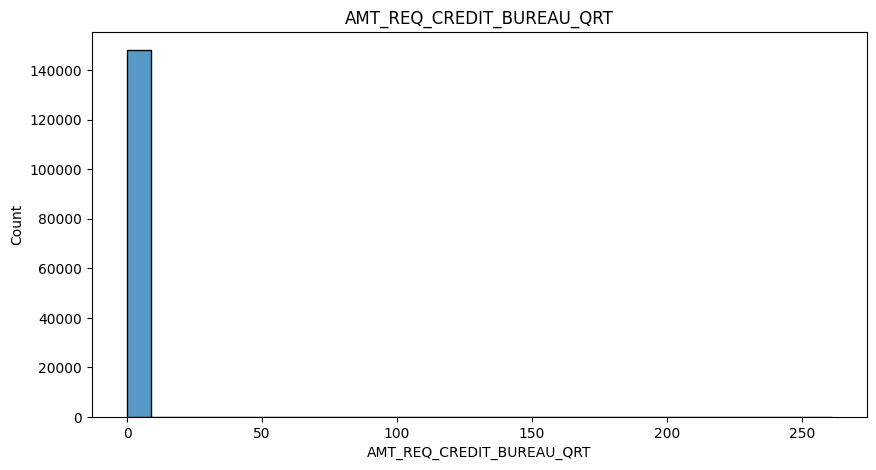

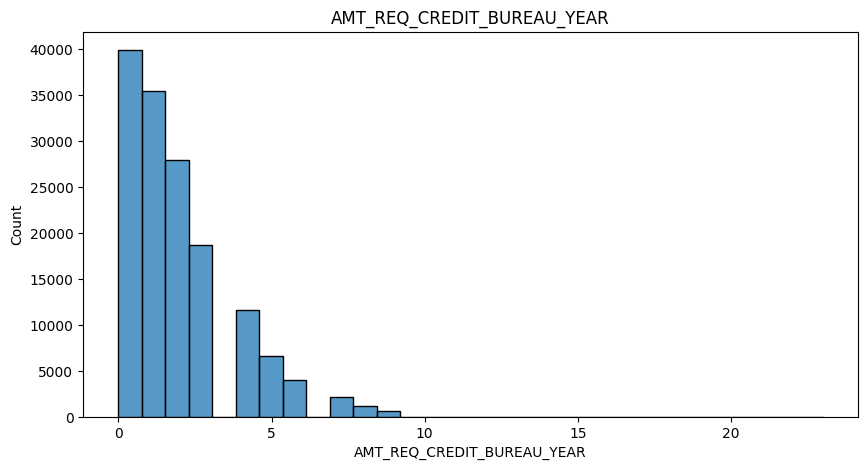

In [111]:

# 項目のリスト
columns = ["NAME_CONTRACT_TYPE", "AMT_INCOME_TOTAL", "OWN_CAR_AGE", "ORGANIZATION_TYPE", "CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "DAYS_EMPLOYED",
           "CNT_FAM_MEMBERS", "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR"]

# 各項目についてヒストグラムを作成
for column in columns:
    plt.figure(figsize=(10, 5))  # グラフのサイズを設定
    sns.histplot(train_original[column].dropna(),
                 kde=False, bins=30)  # ヒストグラムを作成
    plt.title(column)  # グラフのタイトルを設定
    plt.show()  # グラフを



In [112]:
train = train_original[columns]
test = test[columns]

print(len(train))
# 項目それぞれで、欠損値の数を確認
train.isnull().sum()

171202


NAME_CONTRACT_TYPE                 0
AMT_INCOME_TOTAL                   0
OWN_CAR_AGE                   112992
ORGANIZATION_TYPE                  0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                        6
DAYS_EMPLOYED                      0
CNT_FAM_MEMBERS                    2
EXT_SOURCE_1                  118928
EXT_SOURCE_2                     369
EXT_SOURCE_3                   54586
AMT_REQ_CREDIT_BUREAU_HOUR     23116
AMT_REQ_CREDIT_BUREAU_MON      23116
AMT_REQ_CREDIT_BUREAU_QRT      23116
AMT_REQ_CREDIT_BUREAU_YEAR     23116
dtype: int64

In [113]:
# testデータの確認
print(f"test shape: {test.shape}")
test.head(3)


test shape: (61500, 17)


,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,OWN_CAR_AGE,ORGANIZATION_TYPE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,144000.0,NaN,Kindergarten,1,144000.0,961146.0,28233.0,-2372,3.0,NaN,0.720416,NaN,NaN,NaN,NaN,NaN
1,Cash loans,103500.0,NaN,School,0,103500.0,296280.0,16069.5,-1712,2.0,NaN,0.287306,NaN,NaN,NaN,NaN,NaN
2,Cash loans,180000.0,NaN,Trade: type 7,1,180000.0,183694.5,11236.5,-553,2.0,NaN,0.352456,0.389339,0.0,1.0,1.0,1.0


特徴量が50種類もあることが分かります。このnotebookでは、50種類全ての特徴量について分析することはせず、5種類の特徴量に絞って分析を行います。今回のように特徴量が多い場合は、初めから全ての特徴量に対して、分析や前処理を行うのは大変だと思います。なので、初めは少ない特徴量で予測結果を出すことを目標に取り組んでみて、それから扱う特徴量を増やしてみると取り組みやすいです。残りの45種類の特徴量については、今までの教材やこのnotebook等を参考にして、自分の力で分析を行ってみてください。


使用する5種類の特徴量については、様々な処理の説明を行えるように選択しています。

In [114]:
# EXT_SOURCE_2の欠損値を平均値で補完
train["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True)
test["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True)

# EXT_SOURCE_3の欠損値を平均値で補完
train["EXT_SOURCE_3"].fillna(train["EXT_SOURCE_3"].mean(), inplace=True)
test["EXT_SOURCE_3"].fillna(train["EXT_SOURCE_3"].mean(), inplace=True)

fill0_columns = ["AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_MON",
                 "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR"]
# fill0_columnsの欠損値を0で補完
train[fill0_columns] = train[fill0_columns].fillna(0)
test[fill0_columns] = test[fill0_columns].fillna(0)

train.isnull().sum()


NAME_CONTRACT_TYPE                 0
AMT_INCOME_TOTAL                   0
OWN_CAR_AGE                   112992
ORGANIZATION_TYPE                  0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                        6
DAYS_EMPLOYED                      0
CNT_FAM_MEMBERS                    2
EXT_SOURCE_1                  118928
EXT_SOURCE_2                       0
EXT_SOURCE_3                       0
AMT_REQ_CREDIT_BUREAU_HOUR         0
AMT_REQ_CREDIT_BUREAU_MON          0
AMT_REQ_CREDIT_BUREAU_QRT          0
AMT_REQ_CREDIT_BUREAU_YEAR         0
dtype: int64

NAME_CONTRACT_TYPEを数値型に変換します。今回は、「Cash loans」を0に「Revolving loans」を1に変換します。このように、単純に整数に置き換える手法をLabel Encodingと呼びます。

In [115]:
# NAME_CONTRACT_TYPEの数値化（Label Encoding）
train["NAME_CONTRACT_TYPE"].replace(
    {'Cash loans': 0, 'Revolving loans': 1}, inplace=True)
test["NAME_CONTRACT_TYPE"].replace(
    {'Cash loans': 0, 'Revolving loans': 1}, inplace=True)

train.head(5)


,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,OWN_CAR_AGE,ORGANIZATION_TYPE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,112500.0,NaN,School,0,112500.0,755190.0,36328.5,-878,2.0,NaN,0.372591,0.511177,0.0,0.0,0.0,0.0
1,0,225000.0,NaN,XNA,0,225000.0,585000.0,16893.0,365243,2.0,NaN,0.449567,0.553165,0.0,0.0,0.0,1.0
2,0,54000.0,NaN,Postal,0,54000.0,334152.0,18256.5,-523,2.0,NaN,0.569503,0.511177,0.0,0.0,0.0,0.0
3,0,67500.0,NaN,XNA,0,67500.0,152820.0,8901.0,365243,1.0,NaN,0.105235,0.767523,0.0,0.0,0.0,0.0
4,0,157500.0,NaN,Business Entity Type 3,0,157500.0,271066.5,21546.0,-697,2.0,0.342344,0.202490,0.669057,0.0,0.0,0.0,4.0


ORGANIZATION_TYPEを数値型に変換します。今回は、変数のデータ数で数値化します。例えば、「Police」のデータ数が1279、「Bank」のデータ数が1385である場合には、「Police」を1279に、「Bank」を1385に変換します。このようにデータ数に置き換える手法をCount Encodingと呼びます。

In [116]:
# ORGANIZATION_TYPEの数値化（Count Encoding）
organization_ce = train["ORGANIZATION_TYPE"].value_counts()
train["ORGANIZATION_TYPE"] = train["ORGANIZATION_TYPE"].map(organization_ce)
test["ORGANIZATION_TYPE"] = test["ORGANIZATION_TYPE"].map(organization_ce)

train.head(5)

,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,OWN_CAR_AGE,ORGANIZATION_TYPE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,112500.0,NaN,4991,0,112500.0,755190.0,36328.5,-878,2.0,NaN,0.372591,0.511177,0.0,0.0,0.0,0.0
1,0,225000.0,NaN,30898,0,225000.0,585000.0,16893.0,365243,2.0,NaN,0.449567,0.553165,0.0,0.0,0.0,1.0
2,0,54000.0,NaN,1185,0,54000.0,334152.0,18256.5,-523,2.0,NaN,0.569503,0.511177,0.0,0.0,0.0,0.0
3,0,67500.0,NaN,30898,0,67500.0,152820.0,8901.0,365243,1.0,NaN,0.105235,0.767523,0.0,0.0,0.0,0.0
4,0,157500.0,NaN,37943,0,157500.0,271066.5,21546.0,-697,2.0,0.342344,0.202490,0.669057,0.0,0.0,0.0,4.0


OWN_CAR_AGEの処理を行います。まず、不自然な60以上の外れ値を欠損値として置き換えます。

In [117]:
# OWN_CAR_AGEの60以上の値（外れ値）を欠損値扱いする
train.loc[train["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
test.loc[test["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan


次に、OWN_CAR_AGEの欠損値の処理について考えます。元々のOWN_CAR_AGEにはデータ数171202に対して欠損値が112992個ありました。このように欠損値が多い場合には、適切に欠損値を補完することは難しく現実的ではありません。そのため、今回はOWN_CAR_AGEを0～9年、10～19年のように10年単位でグループ分けした後に、One Hot Encodingを行うことで欠損値の対処を行います。

In [118]:
# OWN_CAR_AGEをグループ分け
train["OWN_CAR_AGE"] = train["OWN_CAR_AGE"] // 10
test["OWN_CAR_AGE"] = test["OWN_CAR_AGE"] // 10

train["OWN_CAR_AGE"].unique()


array([nan,  0.,  2.,  1.,  3.,  4.,  5.])

In [119]:
# OWN_CAR_AGEをOne Hot Encoding
train_car_age_ohe = pd.get_dummies(
    train["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")
test_car_age_ohe = pd.get_dummies(
    test["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")

train = pd.concat([train, train_car_age_ohe], axis=1)
test = pd.concat([test, test_car_age_ohe], axis=1)

train.drop('OWN_CAR_AGE', axis=1, inplace=True)
test.drop('OWN_CAR_AGE', axis=1, inplace=True)

train.head(5)


,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,ORGANIZATION_TYPE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,CNT_FAM_MEMBERS,EXT_SOURCE_1,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,OWN_CAR_AGE_0.0,OWN_CAR_AGE_1.0,OWN_CAR_AGE_2.0,OWN_CAR_AGE_3.0,OWN_CAR_AGE_4.0,OWN_CAR_AGE_5.0
0,0,112500.0,4991,0,112500.0,755190.0,36328.5,-878,2.0,NaN,...,0.0,0.0,0.0,0.0,False,False,False,False,False,False
1,0,225000.0,30898,0,225000.0,585000.0,16893.0,365243,2.0,NaN,...,0.0,0.0,0.0,1.0,False,False,False,False,False,False
2,0,54000.0,1185,0,54000.0,334152.0,18256.5,-523,2.0,NaN,...,0.0,0.0,0.0,0.0,False,False,False,False,False,False
3,0,67500.0,30898,0,67500.0,152820.0,8901.0,365243,1.0,NaN,...,0.0,0.0,0.0,0.0,False,False,False,False,False,False
4,0,157500.0,37943,0,157500.0,271066.5,21546.0,-697,2.0,0.342344,...,0.0,0.0,0.0,4.0,False,False,False,False,False,False


In [120]:

# EXT_SOURCE_1を,0.3未満、0.3以上0.5未満、0.5以上0.7未満、0.7以上の4つのグループに分ける
train["EXT_SOURCE_1"] = pd.cut(train["EXT_SOURCE_1"], bins=[
    0, 0.3, 0.5, 0.7, 1.0], right=False)
test["EXT_SOURCE_1"] = pd.cut(test["EXT_SOURCE_1"], bins=[
    0, 0.3, 0.5, 0.7, 1.0], right=False)

# EXT_SOURCE_1をOne Hot Encoding
train_ext_1_ohe = pd.get_dummies(
    train["EXT_SOURCE_1"]).add_prefix("EXT_SOURCE_1_")
test_ext_1_ohe = pd.get_dummies(
    test["EXT_SOURCE_1"]).add_prefix("EXT_SOURCE_1_")

train = pd.concat([train, train_ext_1_ohe], axis=1)
test = pd.concat([test, test_ext_1_ohe], axis=1)

train.drop('EXT_SOURCE_1', axis=1, inplace=True)
test.drop('EXT_SOURCE_1', axis=1, inplace=True)

train.head(5)

print(
    train.isnull().sum()
)

train_head = train.head()
train.head(5)


NAME_CONTRACT_TYPE            0
AMT_INCOME_TOTAL              0
ORGANIZATION_TYPE             0
CNT_CHILDREN                  0
AMT_INCOME_TOTAL              0
AMT_CREDIT                    0
AMT_ANNUITY                   6
DAYS_EMPLOYED                 0
CNT_FAM_MEMBERS               2
EXT_SOURCE_2                  0
EXT_SOURCE_3                  0
AMT_REQ_CREDIT_BUREAU_HOUR    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
OWN_CAR_AGE_0.0               0
OWN_CAR_AGE_1.0               0
OWN_CAR_AGE_2.0               0
OWN_CAR_AGE_3.0               0
OWN_CAR_AGE_4.0               0
OWN_CAR_AGE_5.0               0
EXT_SOURCE_1_[0.0, 0.3)       0
EXT_SOURCE_1_[0.3, 0.5)       0
EXT_SOURCE_1_[0.5, 0.7)       0
EXT_SOURCE_1_[0.7, 1.0)       0
dtype: int64


,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,ORGANIZATION_TYPE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,CNT_FAM_MEMBERS,EXT_SOURCE_2,...,OWN_CAR_AGE_0.0,OWN_CAR_AGE_1.0,OWN_CAR_AGE_2.0,OWN_CAR_AGE_3.0,OWN_CAR_AGE_4.0,OWN_CAR_AGE_5.0,"EXT_SOURCE_1_[0.0, 0.3)","EXT_SOURCE_1_[0.3, 0.5)","EXT_SOURCE_1_[0.5, 0.7)","EXT_SOURCE_1_[0.7, 1.0)"
0,0,112500.0,4991,0,112500.0,755190.0,36328.5,-878,2.0,0.372591,...,False,False,False,False,False,False,False,False,False,False
1,0,225000.0,30898,0,225000.0,585000.0,16893.0,365243,2.0,0.449567,...,False,False,False,False,False,False,False,False,False,False
2,0,54000.0,1185,0,54000.0,334152.0,18256.5,-523,2.0,0.569503,...,False,False,False,False,False,False,False,False,False,False
3,0,67500.0,30898,0,67500.0,152820.0,8901.0,365243,1.0,0.105235,...,False,False,False,False,False,False,False,False,False,False
4,0,157500.0,37943,0,157500.0,271066.5,21546.0,-697,2.0,0.202490,...,False,False,False,False,False,False,False,True,False,False


In [121]:
# AMT_ANNUITY      とCNT_FAM_MEMBERS               の欠損値を平均値で補完
train["AMT_ANNUITY"].fillna(train["AMT_ANNUITY"].mean(), inplace=True)
test["AMT_ANNUITY"].fillna(train["AMT_ANNUITY"].mean(), inplace=True)

train["CNT_FAM_MEMBERS"].fillna(train["CNT_FAM_MEMBERS"].mean(), inplace=True)
test["CNT_FAM_MEMBERS"].fillna(train["CNT_FAM_MEMBERS"].mean(), inplace=True)


print(
    train.isnull().sum()
)


NAME_CONTRACT_TYPE            0
AMT_INCOME_TOTAL              0
ORGANIZATION_TYPE             0
CNT_CHILDREN                  0
AMT_INCOME_TOTAL              0
AMT_CREDIT                    0
AMT_ANNUITY                   0
DAYS_EMPLOYED                 0
CNT_FAM_MEMBERS               0
EXT_SOURCE_2                  0
EXT_SOURCE_3                  0
AMT_REQ_CREDIT_BUREAU_HOUR    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
OWN_CAR_AGE_0.0               0
OWN_CAR_AGE_1.0               0
OWN_CAR_AGE_2.0               0
OWN_CAR_AGE_3.0               0
OWN_CAR_AGE_4.0               0
OWN_CAR_AGE_5.0               0
EXT_SOURCE_1_[0.0, 0.3)       0
EXT_SOURCE_1_[0.3, 0.5)       0
EXT_SOURCE_1_[0.5, 0.7)       0
EXT_SOURCE_1_[0.7, 1.0)       0
dtype: int64


## 3. 機械学習モデルの作成
ここでは、機械学習モデルの作成を行います。

まずは、必要なライブラリを読み込みます。

- train_test_split：データを訓練用データと評価用データに分割する。
- StandardScaler：データを標準化する。
- roc_auc_score：今回の評価指標であるAUCを計算する。

In [122]:
# ライブラリの読み込み
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score


データを説明変数と目的変数に分割します。今回の目的変数は「TARGET」なので、それ以外が説明変数となります。

In [123]:
print(test.columns)
print(train.columns)
print(test.shape)
train.shape

Index(['NAME_CONTRACT_TYPE', 'AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'OWN_CAR_AGE_0.0', 'OWN_CAR_AGE_1.0', 'OWN_CAR_AGE_2.0',
       'OWN_CAR_AGE_3.0', 'OWN_CAR_AGE_4.0', 'OWN_CAR_AGE_5.0',
       'EXT_SOURCE_1_[0.0, 0.3)', 'EXT_SOURCE_1_[0.3, 0.5)',
       'EXT_SOURCE_1_[0.5, 0.7)', 'EXT_SOURCE_1_[0.7, 1.0)'],
      dtype='object')
Index(['NAME_CONTRACT_TYPE', 'AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'OWN_CAR_AGE_0.0', 'OW

(171202, 25)

In [125]:
# 目的変数と説明変数に分割
y = target
X_test = test.values

データを標準化します。標準化とは、平均が0で分散が1となるように値を変換する操作です。ロジスティック回帰やニューラルネットワークなどの一部のモデルでは、このように値のスケールを揃えないと学習が上手くいきません。

In [127]:
# 標準化
sc = StandardScaler()
sc.fit(train)
X_std = sc.transform(train)
X_test_std = sc.transform(X_test)

学習用データのうち、7割を訓練データ、3割を評価データとして分割します。このように、学習データの一部を学習に用いずに、評価用として取っておく手法をホールドアウト法と呼びます。これにより、未知のデータに対する予測精度（汎化性能）を算出することが出来ます。

In [128]:
# 訓練データと評価データに分割
X_train, X_valid, y_train, y_valid = train_test_split(X_std, y, test_size=0.3, stratify=y, random_state=0)

ロジスティック回帰と多層パーセプトロンでモデルを作成してみます。

In [129]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

lr_train_pred = lr.predict_proba(X_train)[:, 1]
lr_valid_pred = lr.predict_proba(X_valid)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, lr_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, lr_valid_pred)}")

Train Score: 0.7209368235044498
Valid Score: 0.7204467008208645


In [130]:
# MLPClassifier
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=0)
mlp.fit(X_train, y_train)

mlp_train_pred = mlp.predict_proba(X_train)[:, 1]
mlp_valid_pred = mlp.predict_proba(X_valid)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, mlp_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, mlp_valid_pred)}")

Train Score: 0.7704356793771543
Valid Score: 0.7074112586249464


つぎに、勾配ブースティング木（GBDT）と呼ばれるモデルを作成してみたいと思います。GBDTは、使いやすさと精度の高さから、Kaggleなどの分析コンペでよく使用されているモデルです。GBDTの特徴として以下のような点が挙げられます。
- 欠損値のあるデータを学習できる。
- 標準化などの値のスケーリングが不要。
- 精度が高い。
- 特徴量間の相互作用が反映される。
- 特徴量が多くても精度が落ちにくく、速度が速い。

今回はGBDTの中でも代表的なxgboostとlightgbmを扱います。

In [131]:
# XGBClassifier
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)

xgb_train_pred = xgb.predict_proba(X_train)[:, 1]
xgb_valid_pred = xgb.predict_proba(X_valid)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, xgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, xgb_valid_pred)}")

Train Score: 0.8492515842078299
Valid Score: 0.7223747976982672


In [132]:
# LGBMClassifier
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=0)
lgb.fit(X_train, y_train)

lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, lgb_valid_pred)}")

Train Score: 0.796928082361591
Valid Score: 0.7283022454936796


ここまでで、4つのモデルを作成しました。ここでは、アンサンブルと呼ばれる複数のモデルを組み合わせることを行います。アンサンブルには、様々な手法がありますが、今回はシンプルに4つのモデルの平均値をとることにします。

In [133]:
train_pred = (lr_train_pred + mlp_train_pred +
              lgb_train_pred + xgb_train_pred)/4
valid_pred = (lr_valid_pred + mlp_valid_pred +
              lgb_valid_pred + xgb_valid_pred)/4

print(f"Train Score: {roc_auc_score(y_train, train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, valid_pred)}")


Train Score: 0.8115022990205853
Valid Score: 0.7318435813550918


今回は、アンサンブルをしても精度の向上には繋がらなかったため、最終的なモデルは一番スコアの高かったxgboostを用いることにします。

## 4. 予測結果の作成
最後にテストデータに対して予測を行い、提出用のcsvファイルを作成します。

In [134]:
# テストデータに対する予測値の作成
pred = xgb.predict_proba(X_test)[:, 1]

In [135]:
# 予測結果を提出用のフォーマットに格納
sample_sub['TARGET'] = pred
sample_sub

,SK_ID_CURR,TARGET
0,171202,0.002195
1,171203,0.004934
2,171204,0.002282
3,171205,0.004507
4,171206,0.006784
...,...,...
61495,232697,0.005227
61496,232698,0.001725
61497,232699,0.001453
61498,232700,0.006658


In [136]:
# 提出用のcsvファイルを作成
sample_sub.to_csv('submission.csv',index=False)

以上で、Home Credit Default Riskコンペのチュートリアルは終了です。今回は、50種類ある特徴量のうち5種類しか使用していないので、まだまだ改善の余地があります。この後は、このnotebookやこれまでの教材を参考にして、さらなるスコアの向上を目指してください！